Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import matplotlib.image as mpimg


In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

!unzip -q "/content/gdrive/My Drive/CNN_assignment.zip"

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [113]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [159]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

from glob import glob
path_list = list(data_dir_train.glob('*/*.jpg'))
print(path_list)

lesion_list = [os.path.basename((os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*/*.jpg'))]
print(len(lesion_list))

dataframe_dict = dict(zip(path_list, lesion_list))

original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])



2239
118
[PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0026992.jpg'), PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0030076.jpg'), PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0028335.jpg'), PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0025196.jpg'), PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0033869.jpg'), PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0026138.jpg'), PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0028231.jpg'), PosixPath('/content/Skin cancer ISIC The International Skin Imagin

In [160]:
original_df['Label'].value_counts()


pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [135]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset="training",
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset="validation",
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [140]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)



['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

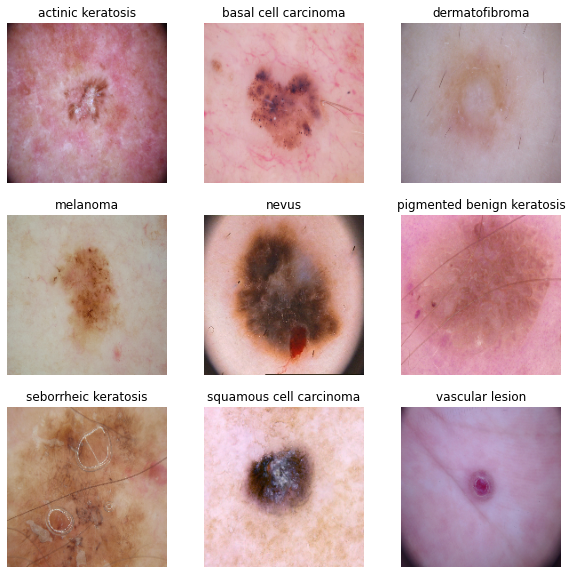

In [30]:
plt.figure(figsize=(10, 10))

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))       
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [178]:
### Your code goes here

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation="softmax")
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [179]:
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [180]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 22, 128)     

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 195s 2s/step - loss: 2.2619 - accuracy: 0.1942 - val_loss: 1.9705 - val_accuracy: 0.2036
Epoch 2/20
56/56 [==============================] - 134s 2s/step - loss: 1.8898 - accuracy: 0.2824 - val_loss: 1.6842 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 133s 2s/step - loss: 1.6455 - accuracy: 0.4102 - val_loss: 1.7582 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 133s 2s/step - loss: 1.4828 - accuracy: 0.4827 - val_loss: 1.4341 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 132s 2s/step - loss: 1.3248 - accuracy: 0.5307 - val_loss: 1.5913 - val_accuracy: 0.4139
Epoch 6/20
56/56 [==============================] - 132s 2s/step - loss: 1.2912 - accuracy: 0.5329 - val_loss: 1.4272 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 132s 2s/step - loss: 1.2148 - accuracy: 0.5686 - val_loss: 1.5837 - val_accuracy: 0.4899
Epoch 8/20
56

### Visualizing training results

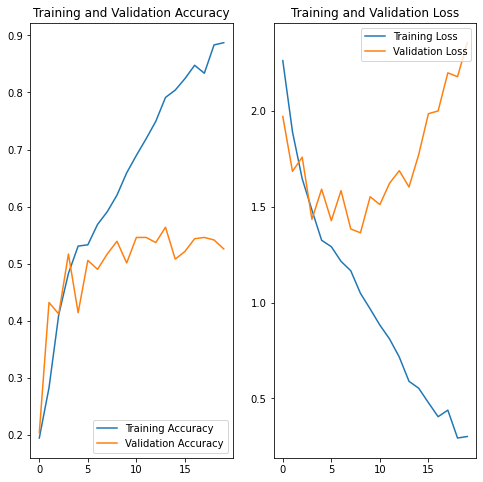

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
These seems to be quick drop in the validation loss and accuracy after inital epochs,which indicates overfitting in the model.

In [70]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom( fill_value=0.0,height_factor=(-0.1, -0.2))
])

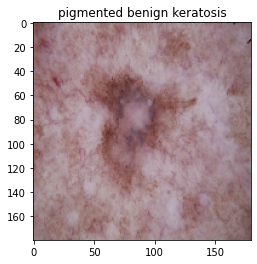

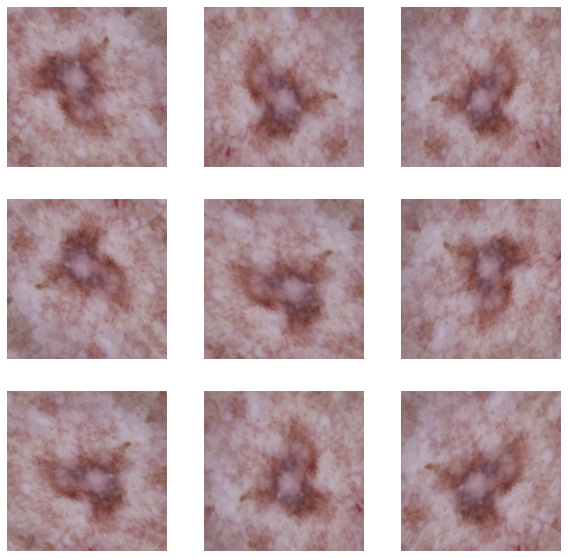

In [72]:


# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

image, label = next(iter(train_ds))
_ = plt.imshow(image[0].numpy().astype('uint8'))
_ = plt.title(class_names[label.numpy()[0]])


image = tf.expand_dims(image, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype('uint8'))
  plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [173]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = tf.keras.Sequential([  
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  data_augmentation,  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.3),   #Adding dropout layer as overfitting is observed
  layers.Dense(len(class_names), activation="softmax")
])


### Compiling the model

In [76]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

In [77]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 93s 2s/step - loss: 2.0418 - accuracy: 0.2589 - val_loss: 1.7615 - val_accuracy: 0.3557
Epoch 2/20
56/56 [==============================] - 88s 2s/step - loss: 1.7397 - accuracy: 0.3683 - val_loss: 1.6542 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 88s 2s/step - loss: 1.6448 - accuracy: 0.3923 - val_loss: 1.6252 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 88s 2s/step - loss: 1.5617 - accuracy: 0.4392 - val_loss: 1.7514 - val_accuracy: 0.3714
Epoch 5/20
56/56 [==============================] - 88s 2s/step - loss: 1.5539 - accuracy: 0.4425 - val_loss: 1.6184 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 88s 2s/step - loss: 1.4770 - accuracy: 0.4738 - val_loss: 1.5227 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 88s 2s/step - loss: 1.4606 - accuracy: 0.4743 - val_loss: 1.5596 - val_accuracy: 0.4787
Epoch 8/20
56/56 [==

### Visualizing the results

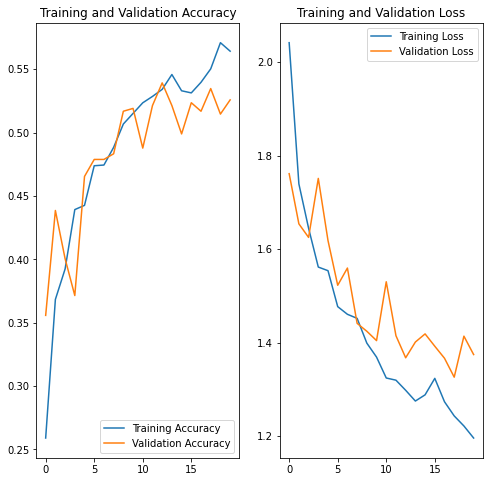

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
There seems to an improvement in the validation loss and validation accuracy of the model.but the overfitting issue still persists in the model as the metrics drop at later stages of epoches

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139


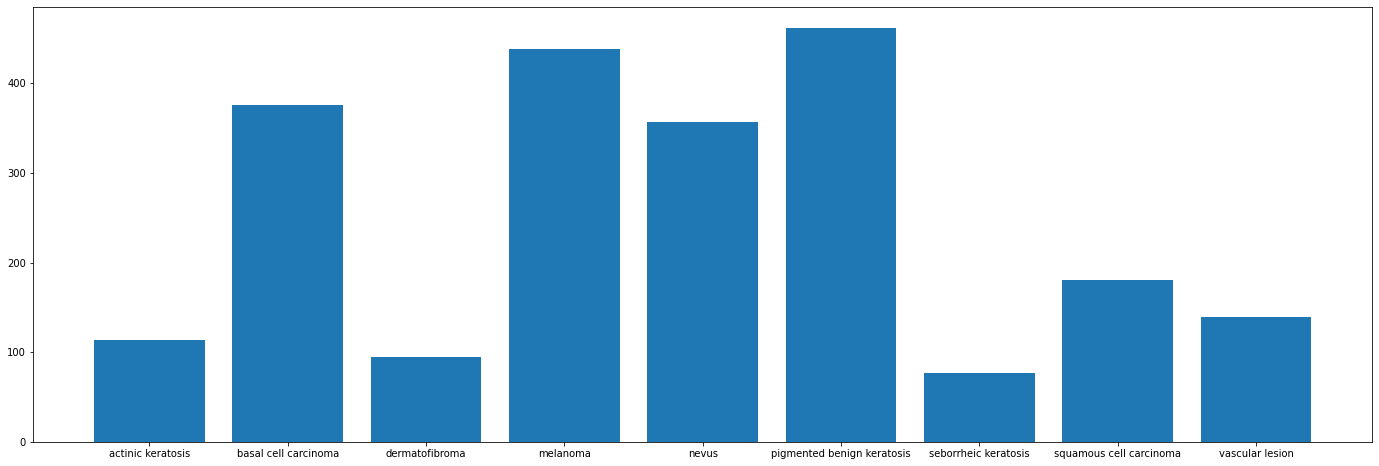

In [ ]:
## Your code goes here.
dict = {}
for i in range(len(class_names)):
  image_count_class = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print(class_names[i] + ": "+str(image_count_class))
  dict[class_names[i]]=image_count_class
 
plt.figure(figsize=(24, 8))
plt.bar(range(len(dict)), list(dict.values()), align='center')
plt.xticks(range(len(dict)), list(dict.keys()))

plt.show()   

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
**'seborrheic keratosis' class have least number of samples**
#### - Which classes dominate the data in terms proportionate number of samples?
**'pigmented benign keratosis' and 'melanoma' have most number of samples in the train dataset.**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [81]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [83]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F469FC1AAD0>: 100%|██████████| 500/500 [00:20<00:00, 24.66 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F469F047290>: 100%|██████████| 500/500 [00:18<00:00, 26.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F46A1339C90>: 100%|██████████| 500/500 [00:19<00:00, 25.05 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F46A0657410>: 100%|██████████| 500/500 [01:42<00:00,  4.88 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F46A0220A10>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2314x2067 at 0x7F469FC39150>: 100%|██████████| 500/500 [01:39<00:00,  5.03 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F46A1329C10>:   0%|          | 1/500 [00:00<01:05,  7.66 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F469EFB6950>: 100%|██████████| 500/500 [00:19<00:00, 25.25 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F46A14AA990>: 100%|██████████| 500/500 [00:47<00:00, 10.51 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F469F076850>: 100%|██████████| 500/500 [00:20<00:00, 24.26 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F469EDC95D0>: 100%|██████████| 500/500 [00:19<00:00, 25.30 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [84]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [115]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026206.jpg_a1dc06e5-c5a2-49f8-a35b-05cc7f867a13.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028499.jpg_b0bc3e02-b5fe-40c9-b0ae-2b6c01cabbbd.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024925.jpg_4f716f90-b91d-4eec-ba3e-196ec3e0a20a.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025331.jpg_24cec363-ba72-48fc-8763-cd51d6e5024c.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026100.jpg_d4a5f7bf-41b2-410c-b0da-402e

In [161]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [162]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [163]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [170]:
new_df['Label'].value_counts()


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [166]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [168]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [172]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [174]:
## your code goes here
model = tf.keras.Sequential([  
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.3),   #Adding dropout layer as overfitting is observed
  layers.Dense(len(class_names), activation="softmax")
])



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [175]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [176]:
epochs = 30
## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 227s 1s/step - loss: 2.0132 - accuracy: 0.2255 - val_loss: 1.6374 - val_accuracy: 0.3875
Epoch 2/30
169/169 [==============================] - 222s 1s/step - loss: 1.5993 - accuracy: 0.3943 - val_loss: 1.4934 - val_accuracy: 0.4269
Epoch 3/30
169/169 [==============================] - 222s 1s/step - loss: 1.4341 - accuracy: 0.4523 - val_loss: 1.3694 - val_accuracy: 0.4818
Epoch 4/30
169/169 [==============================] - 224s 1s/step - loss: 1.3122 - accuracy: 0.4911 - val_loss: 1.2235 - val_accuracy: 0.5501
Epoch 5/30
169/169 [==============================] - 223s 1s/step - loss: 1.1204 - accuracy: 0.5762 - val_loss: 1.0316 - val_accuracy: 0.6162
Epoch 6/30
169/169 [==============================] - 222s 1s/step - loss: 0.9552 - accuracy: 0.6419 - val_loss: 0.9129 - val_accuracy: 0.6451
Epoch 7/30
169/169 [==============================] - 222s 1s/step - loss: 0.8489 - accuracy: 0.6853 - val_loss: 0.8631 - val_accuracy: 0.6867

#### **Todo:**  Visualize the model results

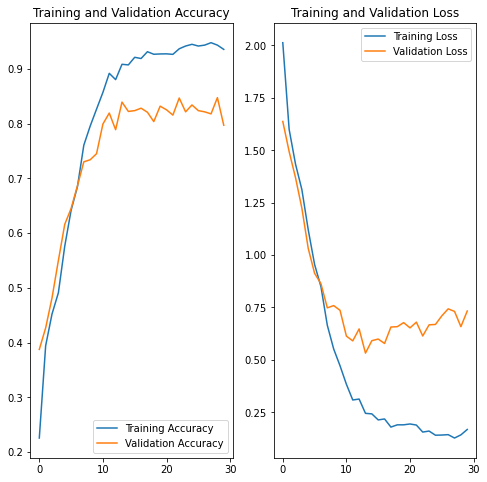

In [177]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Although class rebalance did helped in decrese the overfitting to a large extent there still seems to ba drop in the validation loss in the later stages of epoches.overfitting has been decreased to a large extent.